### Acesso ao Drive

In [2]:
# Acesso a pasta do drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


### GPU

In [ ]:
# Verificação de GPU
from tensorflow.python.client import device_lib
import tensorflow as tf
print('#'*100)
print('GPU')
print('#'*100)
print('Devices\n')
print(device_lib.list_local_devices())
print('#'*100)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
print('#'*100)


In [ ]:
# !ls /content/drive/MyDrive/'DEEP LEARNING'/projeto/HDR+/images

### Image Dataset

In [3]:
DATASET_PATH = '/content/drive/MyDrive/DeepLearning/HDR+/images'
SIZE = 320

In [4]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow
import cv2

def load_dataset(files_path):
  images = []
  for file in os.listdir(files_path):
    image_path = os.path.join(files_path, file)
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    images.append(image)
  return images

In [5]:
data_original = load_dataset(DATASET_PATH)

In [6]:
def resize_images(images):
    images_resized = []
    for image in images:
      image_res = cv2.resize(image,(SIZE,SIZE),interpolation = cv2.INTER_AREA) # redimensionar para 320x320
      images_resized.append(image_res)
    
    return images_resized
data_resized = resize_images(data_original)

In [7]:
del data_original

In [ ]:
# def gray_scale_data(list_images_rgb):
#   images = []
#   for image in list_images_rgb:
#     img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#     images.append(img_gray)
#   return images
# data_gray = gray_scale_data(data_resized)

### Verificação das Imagens

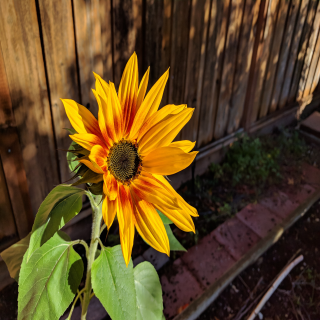

In [8]:
cv2_imshow(data_resized[5])

In [ ]:
# cv2_imshow(data_gray[0])

In [ ]:
data_resized[0].shape

(320, 320, 3)

In [ ]:
# print(type(data_gray))
# print(type((np.array(data_gray))))

print(type(data_resized))
print(type((np.array(data_resized))))

data_resized = np.array(data_resized)

<class 'list'>
<class 'numpy.ndarray'>


### HDR Autoencoder

In [ ]:
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [ ]:
shape = data_resized[5].shape

In [ ]:

#encoder
encoder_input = keras.Input(shape=shape, name = "img_input")

# Conv Block
x = keras.layers.Conv2D(32, 2, activation="relu", padding="same")(encoder_input)
x = keras.layers.Conv2D(32, 2, activation="relu", padding="same")(x)
x = keras.layers.AveragePooling2D((2,2))(x)

# Conv Block
x = keras.layers.Conv2D(64, 2, activation="relu", padding="same")(x)
x = keras.layers.Conv2D(64, 2, activation="relu", padding="same")(x)
x = keras.layers.AveragePooling2D((2,2))(x)

# Conv Block - # Encoder output
x = keras.layers.Conv2D(128, 2, activation="relu", padding="same")(x)
encoder_output = keras.layers.AveragePooling2D((2,2),name="Encoder_Output-Comp_Rep")(x)

# encoder model
encoder = keras.Model(encoder_input,encoder_output, name="encoder")

#decoder
# DeConv block
decoder_input = keras.layers.Conv2DTranspose(64, 2, activation="relu", padding="same")(encoder_output)
x = keras.layers.Conv2DTranspose(64, 2, activation="relu", padding="same")(x)
x = keras.layers.UpSampling2D((2,2))(x)

# DeConv block
x = keras.layers.Conv2DTranspose(32, 2, activation="relu", padding="same")(x)
x = keras.layers.Conv2DTranspose(32, 2, activation="relu", padding="same")(x)
x = keras.layers.UpSampling2D((2,2))(x)


# Decoder output
decoder_output = keras.layers.Conv2D(3, 3, padding="same", name="Decoder_Output")(x)

# decoder model
autoencoder = keras.Model(encoder_input, decoder_output, name="autoencoder")


opt = keras.optimizers.Adam(learning_rate=0.001)

autoencoder.summary()
autoencoder.compile(opt,loss="mse",metrics=['accuracy'])



Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img_input (InputLayer)      [(None, 320, 320, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 320, 320, 32)      416       
                                                                 
 conv2d_1 (Conv2D)           (None, 320, 320, 32)      4128      
                                                                 
 average_pooling2d (AverageP  (None, 160, 160, 32)     0         
 ooling2D)                                                       
                                                                 
 conv2d_2 (Conv2D)           (None, 160, 160, 64)      8256      
                                                                 
 conv2d_3 (Conv2D)           (None, 160, 160, 64)      16448     
                                                       

In [ ]:
# gpu_options = tf.GPUOptions(allow_growth=True)
# session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

GPU_NAME = tf.test.gpu_device_name()
with tf.device(GPU_NAME):
  epochs = 1000
  history = autoencoder.fit(data_resized, data_resized,epochs=epochs, validation_split=0.1,verbose=1)

Epoch 1/1000
5/5 [==============================] - 7s 1s/step - loss: 8037.4546 - accuracy: 0.5227 - val_loss: 2867.6514 - val_accuracy: 0.6770
Epoch 2/1000
5/5 [==============================] - 4s 745ms/step - loss: 2189.4675 - accuracy: 0.4983 - val_loss: 2011.0908 - val_accuracy: 0.2774
Epoch 3/1000
5/5 [==============================] - 4s 744ms/step - loss: 2038.3750 - accuracy: 0.2992 - val_loss: 1541.2206 - val_accuracy: 0.0493
Epoch 4/1000
5/5 [==============================] - 4s 741ms/step - loss: 1463.2682 - accuracy: 0.1115 - val_loss: 1136.3917 - val_accuracy: 0.1592
Epoch 5/1000
5/5 [==============================] - 4s 742ms/step - loss: 1250.2369 - accuracy: 0.4322 - val_loss: 1036.7620 - val_accuracy: 0.6531
Epoch 6/1000
5/5 [==============================] - 4s 739ms/step - loss: 1114.4590 - accuracy: 0.5374 - val_loss: 1011.6213 - val_accuracy: 0.5433
Epoch 7/1000
5/5 [==============================] - 4s 745ms/step - loss: 1013.1339 - accuracy: 0.5428 - val_loss: 

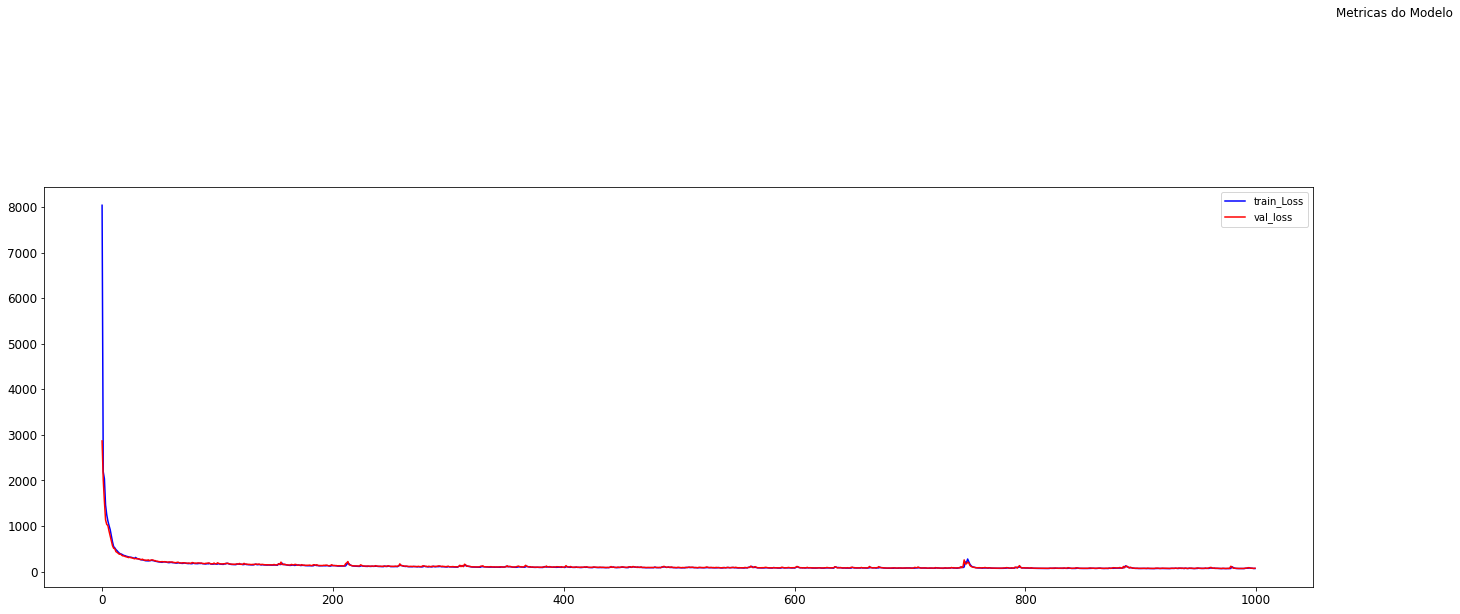

In [ ]:
# Plotting Metrics for evaluate the model
# Imports para formatação dos gráficos
import matplotlib as m
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'
from matplotlib.pylab import rcParams 
rcParams['figure.figsize'] = 50,25


plt.suptitle('Metricas do Modelo')

plt.subplot(3,2,1)
plt.plot(history.history['loss'],label='train_Loss',color = 'Blue')
plt.plot(history.history['val_loss'],label='val_loss',color = 'red')

plt.legend(loc='best')
plt.show()

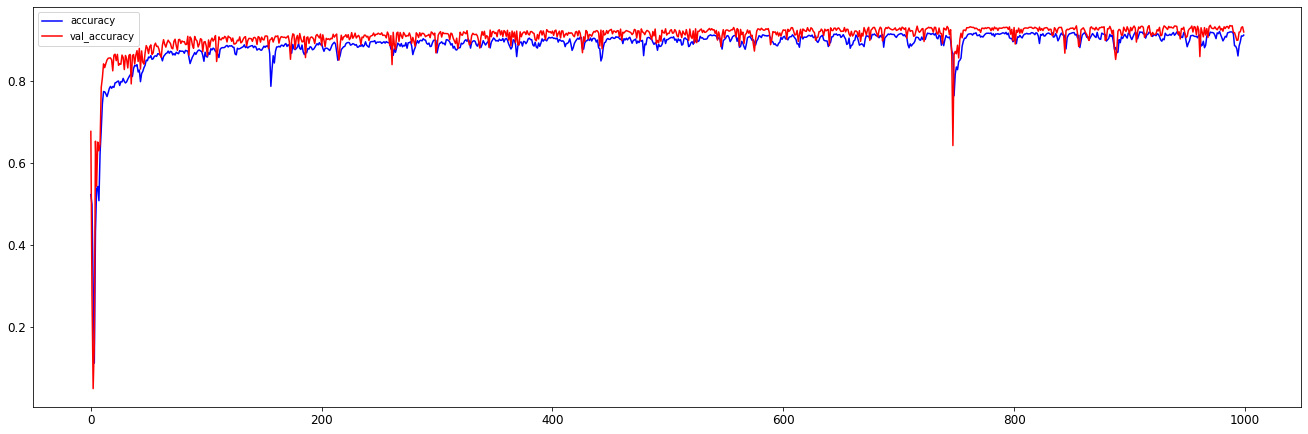

In [ ]:
plt.subplot(3,2,2)
plt.plot(history.history['accuracy'],label='accuracy',color = 'Blue')
plt.plot(history.history['val_accuracy'],label='val_accuracy',color = 'red')

plt.legend(loc='best')

plt.show()

In [ ]:
# Encodificando a Imagem
encoded_image = encoder.predict([data_resized[5].reshape(-1,SIZE,SIZE,3)])[0]

# Gerando a image HDR
image_HDR_generated = autoencoder.predict([data_resized[5].reshape(-1,SIZE,SIZE,3)])[0] # predicao
# image_resize_inverso = cv2.resize(au_res,(1500,1500),interpolation = cv2.INTER_AREA)# redimensionar de 320x320 para uma scala maior

In [ ]:
encoded_image.shape

(40, 40, 128)

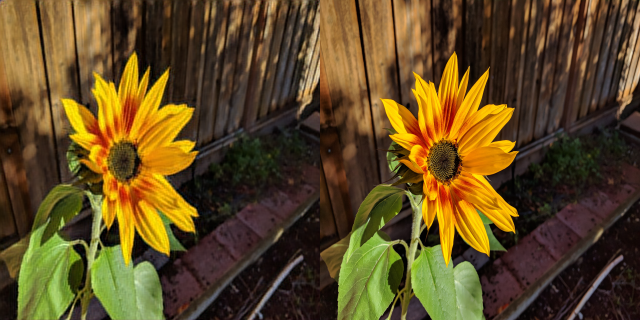

In [ ]:
# concatenate image Horizontally
gen_ori = np.concatenate((image_HDR_generated, data_resized[5]), axis=1)
# gen_ori = np.concatenate((gen_ori, encoded_image), axis=0)
cv2_imshow(gen_ori)


In [ ]:
# average pooling
num_imgs = len(data_resized)
scale = SIZE
name_model = f'autoencoder_HDR_{num_imgs}imgs_{scale}escala_{epochs}epochs_averagePooling.h5'
SAVE_PATH_MODEL = '/content/drive/MyDrive/DeepLearning/HDR+/'+name_model
print(SAVE_PATH_MODEL)

/content/drive/MyDrive/DeepLearning/HDR+/autoencoder_HDR_153imgs_320escala_1000epochs_averagePooling.h5


In [ ]:
autoencoder.save(SAVE_PATH_MODEL)

### Testando com ruidos na Image

In [10]:
MODEL_PATH = '/content/drive/MyDrive/DeepLearning/HDR+/autoencoder_HDR_153imgs_320escala_1000epochs_averagePooling.h5'
model = keras.models.load_model(MODEL_PATH)


In [12]:
# # add noisy to the image
# Parameters
# ----------
# image : ndarray
#     Input image data. Will be converted to float.
# mode : str
#     One of the following strings, selecting the type of noise to add:

#     'gauss'     Gaussian-distributed additive noise.
#     'poisson'   Poisson-distributed noise generated from the data.
#     's&p'       Replaces random pixels with 0 or 1.
#     'speckle'   Multiplicative noise using out = image + n*image,where
#                 n is uniform noise with specified mean & variance.


import numpy as np
import os
import cv2
def noisy(noise_typ,image):
  if noise_typ == "gauss":
    row,col,ch= image.shape
    mean = 0
    var = 0.1
    sigma = var**0.5
    gauss = np.random.normal(mean,sigma,(row,col,ch))
    gauss = gauss.reshape(row,col,ch)
    noisy = image + gauss
    return noisy
  elif noise_typ == "s&p":
    row,col,ch = image.shape
    s_vs_p = 0.5
    amount = 0.004
    out = np.copy(image)
    # Salt mode
    num_salt = np.ceil(amount * image.size * s_vs_p)
    coords = [np.random.randint(0, i - 1, int(num_salt))
            for i in image.shape]
    out[coords] = 1

    # Pepper mode
    num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
    coords = [np.random.randint(0, i - 1, int(num_pepper))
            for i in image.shape]
    out[coords] = 0
    return out
  elif noise_typ == "poisson":
    vals = len(np.unique(image))
    vals = 2 ** np.ceil(np.log2(vals))
    noisy = np.random.poisson(image * vals) / float(vals)
    return noisy
  elif noise_typ =="speckle":
    row,col,ch = image.shape
    gauss = np.random.randn(row,col,ch)
    gauss = gauss.reshape(row,col,ch)        
    noisy = image + image * gauss
    return noisy

noise = noisy("speckle",data_resized[5])

In [13]:
image_denoised = model.predict([noise.reshape(-1,SIZE,SIZE,3)])[0] # predicao


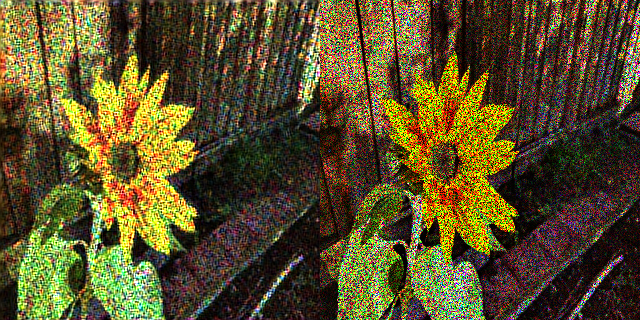

In [25]:
# concatenate image Horizontally
img = np.concatenate((image_denoised,noise), axis=1)
cv2_imshow(img)

### Avaliando com fotos normais

In [46]:

IMAGES_ARTICLE_PATH = '/content/drive/MyDrive/DeepLearning/HDR+/images_test/image_article'

NORMAL_IMAGE_DATASET_PATH = '/content/drive/MyDrive/DeepLearning/HDR+/images_test/normal_images_dataset'

In [47]:
imagesArticle = load_dataset(IMAGES_ARTICLE_PATH)
imagesNormal = load_dataset(NORMAL_IMAGE_DATASET_PATH)

In [48]:
imagesNormal_0 = cv2.resize(imagesNormal[0],(SIZE,SIZE),interpolation = cv2.INTER_AREA) # redimensionar para 320x320


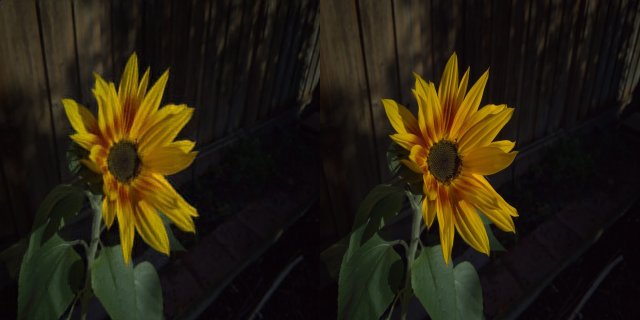

In [49]:
image_normal = model.predict([imagesNormal_0.reshape(-1,SIZE,SIZE,3)])[0] # predicao
img = np.concatenate((image_normal, imagesNormal_0), axis=1)
cv2_imshow(img)

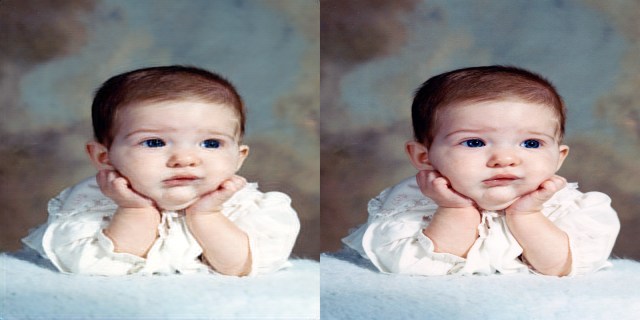

In [50]:
imagesNormal_1 = cv2.resize(imagesNormal[1],(SIZE,SIZE),interpolation = cv2.INTER_AREA) # redimensionar para 320x320
pred_1 = model.predict([imagesNormal_1.reshape(-1,SIZE,SIZE,3)])[0] # predicao
img = np.concatenate((pred_1, imagesNormal_1), axis=1)
cv2_imshow(img)

In [27]:
church_normal = cv2.resize(imagesArticle[0],(SIZE,SIZE),interpolation = cv2.INTER_AREA) # redimensionar para 320x320
church_article = cv2.resize(imagesArticle[1],(SIZE,SIZE),interpolation = cv2.INTER_AREA) # redimensionar para 320x320

motion_normal = cv2.resize(imagesArticle[2],(SIZE,SIZE),interpolation = cv2.INTER_AREA) # redimensionar para 320x320
motion_article = cv2.resize(imagesArticle[3],(SIZE,SIZE),interpolation = cv2.INTER_AREA) # redimensionar para 320x320


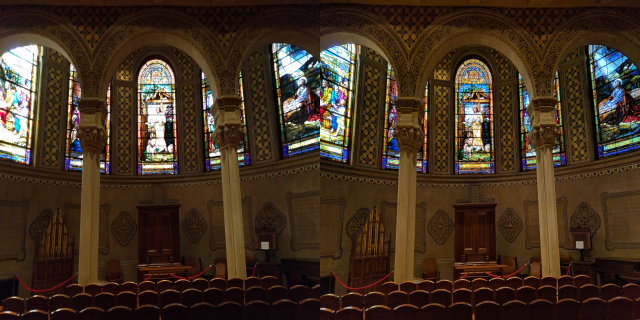

In [28]:
img = np.concatenate((church_normal, church_article), axis=1)
cv2_imshow(img)

In [36]:
my_church = model.predict([church_normal.reshape(-1,SIZE,SIZE,3)])[0]


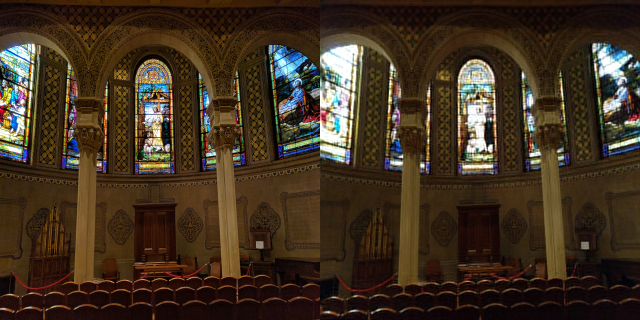

In [37]:
img = np.concatenate((church_article, my_church), axis=1)
cv2_imshow(img)

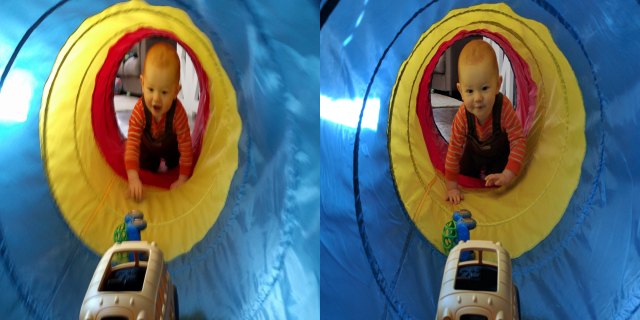

In [38]:
img = np.concatenate((motion_normal, motion_article), axis=1)
cv2_imshow(img)

In [39]:
my_motion = model.predict([motion_normal.reshape(-1,SIZE,SIZE,3)])[0]

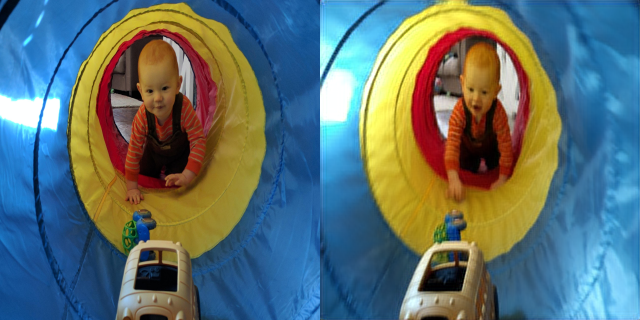

In [41]:
img = np.concatenate((motion_article, my_motion), axis=1)
cv2_imshow(img)

### Autoencoder - Exemplo

In [1]:
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2

# dataset = load_dataset(DATASET_PATH)
# img = cv2.imread(dataset[0], cv2.IMREAD_UNCHANGED)
# img.shape

11501568/11490434 [==============================] - 1s 0us/step
Image Dimensions : (28, 28)
number_features: 784


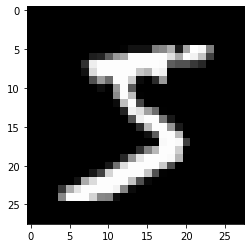

In [ ]:
(x_train, y_train) , (x_test, y_test) = tf.keras.datasets.mnist.load_data()
plt.imshow(x_train[0], cmap="gray")

def prod(val) :  
    res = 1 
    for ele in val:  
        res *= ele  
    return res   
print("Image Dimensions : " + str(x_train[0].shape))  
res = prod(list(x_train[0].shape))
print(f'number_features: {res}')

In [ ]:
type(x_train)

numpy.ndarray

In [ ]:
x_train

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [ ]:
# Colocar os dados para um intervalo 0-1
x_train = x_train/255.0
x_test = x_test/255.0

In [ ]:
# Definindo o encoder
# (28,28,1) - 1 = channel if rgb - 3
encoder_input = keras.Input(shape=(28,28,1), name = "img_input")
x = keras.layers.Flatten()(encoder_input) # flatten to 784 features - unique vector
encoder_output = keras.layers.Dense(64, activation="relu")(x)

# encoder model
encoder = keras.Model(encoder_input,encoder_output, name="encoder")

decoder_input = keras.layers.Dense(784, activation="relu")(encoder_output)
# y = keras.layers.Dense(784, activation="relu")(decoder_input)
decoder_output = keras.layers.Reshape((28,28))(decoder_input)


opt = keras.optimizers.Adam(learning_rate=0.001)

autoencoder = keras.Model(encoder_input, decoder_output, name="autoencoder")
autoencoder.summary()
autoencoder.compile(opt,loss="mse")
GPU_NAME = tf.test.gpu_device_name()
with tf.device(GPU_NAME):
  autoencoder.fit(x_train, x_train,epochs=3,batch_size=32, validation_split=0.1,verbose=1)

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img_input (InputLayer)      [(None, 28, 28, 1)]       0         
                                                                 
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                50240     
                                                                 
 dense_5 (Dense)             (None, 784)               50960     
                                                                 
 reshape_1 (Reshape)         (None, 28, 28)            0         
                                                                 
Total params: 101,200
Trainable params: 101,200
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
1688/1688 [============================

[0.2555895  1.968465   1.3286201  0.91170496 1.815921   0.45576277
 3.526735   0.33532932 1.4865514  1.2634695  0.79437596 1.1186975
 0.7550578  0.9382782  0.54013926 2.064937   0.5427839  1.5481257
 1.4961191  1.2560862  1.6048148  1.1824168  1.2161957  0.23677626
 1.4854591  2.5386875  0.762648   0.5928265  1.7463647  0.
 0.88049066 1.0639563  0.36897597 0.31973183 0.7315742  1.0833267
 1.320331   0.8559945  1.1110659  2.3199797  0.943492   1.8851058
 0.19720758 0.5475954  0.47418502 1.0197856  1.253569   1.8268601
 1.7822517  1.6531773  1.1879455  0.         1.6043998  1.0912193
 0.8296036  0.38622734 0.76569504 1.5071433  2.7035744  0.44840384
 0.43620726 1.0019163  1.2140305  0.39087236]
(64,)


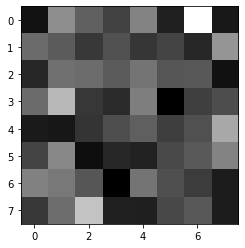

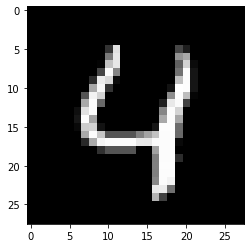

In [ ]:
example = encoder.predict([x_test[4].reshape(-1,28,28,1)])[0]
print(example)
print(example.shape)
# imagem condensada
plt.imshow(example.reshape((8,8)),cmap="gray")
plt.show()
plt.imshow(x_test[4],cmap="gray")
plt.show()

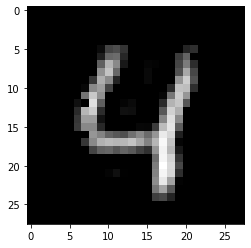

In [ ]:
au_res = autoencoder.predict([x_test[4].reshape(-1,28,28,1)])[0]
plt.imshow(au_res,cmap="gray")

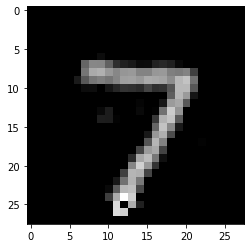

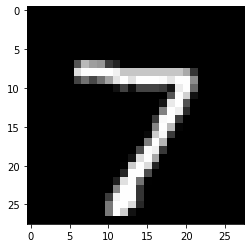

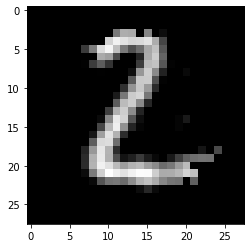

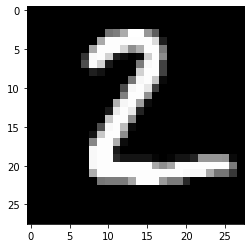

In [ ]:
from google.colab.patches import cv2_imshow
import cv2
# img = cv2.imread(train_data[0], cv2.IMREAD_UNCHANGED)
# cv2_imshow(img)
for d in x_test[:2]:  # just show 5 examples, feel free to show all or however many you want!

    ae_out = autoencoder.predict([ d.reshape(-1, 28, 28, 1) ])[0] 
    plt.imshow(ae_out,cmap="gray")
    plt.show()
    plt.imshow(np.array(d),cmap="gray")
    plt.show()

    cv2.waitKey(1000) 

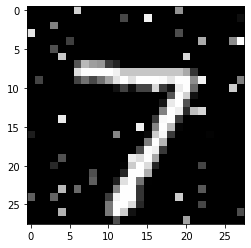

In [ ]:
# add noisy to the image
import random
def add_noise(img, random_chance=5):
    noisy = []
    for row in img:
        new_row = []
        for pix in row:
            if random.choice(range(100)) <= random_chance: 
                new_val = random.uniform(0, 1)
                new_row.append(new_val)
            else:
                new_row.append(pix)
        noisy.append(new_row)
    return np.array(noisy)
noise = add_noise(x_test[0])
plt.imshow(noise,cmap="gray")
plt.show()

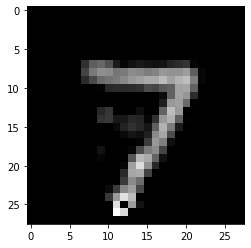

In [ ]:
ae_out = autoencoder.predict([ noise.reshape(-1, 28, 28, 1) ])[0] 
plt.imshow(ae_out,cmap="gray")